# Libraries

In [1]:
using LinearAlgebra
using Plots
#gr()
#pyplot()#
pgfplotsx()
using LaTeXStrings
# theme(:dark)|
 theme(:wong)
#theme(:default)

# Parameter

In [2]:
# parameters of the model 
β = 3  # cost of effort
γ = 1/4  # intensity of synergies
n = 5  # Number of workers

# mathematical constants
Id = Matrix{Int}(I,n,n) # Identity matrix nxn
ones_ = fill(1,n); # vector of ones

# ploting configuration variables
font_size = 15; # font size for ploting


## Model Solution


**Single wage**

Optimal effort and wage:
$$a^*=a_i^*=\frac{1}{2(\beta -\frac{\gamma}{n}\bar{g})}\qquad \forall i$$
$$w^*=\frac{\beta}{4(\beta -\frac{\gamma}{n}\bar{g})^2}$$ 
where $\bar{g}= \sum_i \sum_j g_{ij}$.

Optimal profit:

$$\pi_s* =\frac{n^2}{4(n\beta -\gamma\bar{g})} $$

**Wage discrimination**

Optimal effort and wage:
$$\begin{aligned}
a_d &=\frac{1}{2} \beta\left[I-\frac{\gamma}{2 \beta}\left(G+G^{T}\right)\right]^{-1} \mathbb{1}_n = \frac{1}{2\beta} \mathcal{K}\left(\frac{\gamma}{2\beta}, G+G^{T}\right) \\
w_d &=\frac{1}{2}\left[I-\frac{\gamma}{2 \beta}\left(G+G^{T}\right)\right]^{-1} \mathbb{1}_n = \frac{\beta}{2}\mathcal{K}\left(\frac{\gamma}{2\beta}, G+G^{T}\right) o \mathcal{K}\left(\frac{\gamma}{2\beta}, G+G^{T}\right)
\end{aligned}$$

Optimal profit:

$$\pi_d =\Big[ \mathbf{1}^T+ ([ 2\beta \mathbf{I}-\gamma (G + G^T) ]^{-1} \mathbf{1})^T[\gamma G-\beta I]\Big] [ 2\beta \mathbf{I}-\gamma (G + G^T) ]^{-1} \mathbf{1}$$
which in terms of Katz-Bonacich centralities is 
$$\pi_d =\Big[ \mathbf{1}^T+\frac{1}{2\beta} \mathcal{K}(G + G^T,\frac{\gamma}{2\beta})^T[\gamma G-\beta I]\Big]\frac{1}{2\beta} \mathcal{K}(G + G^T,\frac{\gamma}{2\beta})$$

In [3]:
# Utils
function initialize_parameters(gamma, beta, num_workers)
    global β = gamma  # cost of effort
    global γ = beta # intensity of synergies
    global n = num_workers  # Number of workers
    global Id = Matrix{Int}(I,n,n) #Identity matrix nxn
    global ones_ = fill(1,n) #vector of ones
end

# If method return true, this Condition ensures that Bonacich Matrix will be positive
function condition_largest_eigenvalue(M,delta)
    larg_eig = findmax(eigvals(M))[1]
    #println("larg_eig ", larg_eig ," , delta ",delta," delta*larg " ,delta*larg_eig)
    return larg_eig*delta<1
end

function symmetrized_network(M)
   return M + M'
end

# Return the Katz-Bonacich centrality vector (Popularity measure)
function katz_bonacich(delta, M)
    #println("---", condition_largest_eigenvalue(M,delta))
    return inv(Id - delta*M)*ones_
end

katz_bonacich (generic function with 1 method)

In [4]:
############### Model Perfect Discrimination ############

#effort function of perfect discrimination
function effort(beta, M, gamma)
    delta = gamma/(2*beta)
    return katz_bonacich(delta, symmetrized_network(M))./(2*beta)
end

#wage function of perfect discrimination
function wage(beta, M, gamma)
    delta = gamma/(2*beta)
    return beta.*(katz_bonacich(delta, symmetrized_network(M))./(2*beta)).^2
end

############### Model Single Wage ####################

#effort function of single wage setting
function effort_single(beta, M, gamma)
    g_bar = ones_' *M* ones_
    n_ = size(M)[1]
    return 1/(2*(beta - (gamma*g_bar)/n_))
end

#wage function of single wage setting
function wage_single(beta, M, gamma)
    g_bar = ones_' *M* ones_
    n_ = size(M)[1]
    return beta/(4*(beta - (gamma*g_bar)/n_)^2)
end

function profit_single_ver1(beta, M, gamma)
    eff_ =effort_single(beta,M,gamma)
    g_bar = ones_' *M* ones_
    n_ = size(M)[1]
    return eff_ * n_ + (gamma*g_bar -n_* β)* eff_^2
end

function profit_single(beta, M, gamma)
    n_ = size(M)[1]
    ones_ = fill(1,n_)
    g_bar = ones_' *M* ones_ 
    return (n_^2)/(4*(n_*beta-gamma* g_bar))
end

############## Functions common to both models ##########

# output function of perfect discrimination
function output(effort, M, gamma)
    return ones_'*effort + gamma*effort'*M*effort
end

function sum_efforts(effort, M, gamma)
    return ones_'*effort
end

function profit(M,gamma,effort,wage)
   return output(effort, M,gamma) - wage'*ones_
end

# function profit(M,gamma,beta)
#     eff = effort(beta,M,gamma)
#     if eff<fill(0,size(M)[1])
#         print("error")
#     end
#     wag = wage(beta,M,gamma)
#    return output(eff, M,gamma) - wag'*ones_
# end

function profit(M,gamma,beta)
    delta = gamma/(2*beta)
    n_ = size(M)[1]
    ones_ = fill(1,n_)
    eff = katz_bonacich(delta, M + M')/(2*beta)
    return  ones_'*eff + gamma*eff'*M*eff - beta*eff'*eff 
end



function utilities(effort, wage,beta)
    return wage-beta*effort.^2
end

###################### no network ###########################

function profit_no_network(n,beta)
   return n/(4*beta)
end



profit_no_network (generic function with 1 method)

In [5]:
# Print the solution for all variables in the different settings
function printer(beta, gamma, M)
    println("**************Parameters************")
    println("beta :",β," gamma: ",γ," n: ",n )
    println("************************************")
    Effort = effort(beta, M, gamma)
    Wage = wage(beta, M, gamma)
    Output = output(Effort, M, gamma)
    Profit1 = profit(M, gamma, Effort, Wage)
    Profit2 = profit(M, gamma, beta)
#     Profit1 = 1
    Profit_no_network =  profit_no_network(size(M)[1],beta)
    Utilities = utilities(Effort, Wage,beta)
    println("effort: ", Effort)
    println("wage: ", Wage)
    println("output: ", Output)
    println("profit1: ", Profit1)
    println("profit2: ", Profit2)
    println("profit_no_network: ", Profit_no_network)
    #println("utilities: ", Utilities)
end

function print_parameters()
    println("**************Parameters************")
    println("beta :",β," gamma: ",γ," n: ",n )
    println("************************************")
end

print_parameters (generic function with 1 method)

# Simulation 

We generate different network structures to illustrate the generalization of our results. 
* uniformly random
* stars
* lines
* preferential attachment

In [6]:
#Generating uniformly random matrixes
function random_matrix(beta, n, gamma, num = 0)
    if num == 0
        num = n
    end
    delta = gamma/(beta)
    count = 0
    rand_mat = [if j > i rand()/(num*delta) else 0 end for i in 1:n, j in 1:n]
    while !condition_largest_eigenvalue(rand_mat+rand_mat',delta) #& count < 100000
        rand_mat = [if j > i rand()/(num*delta) else 0 end for i in 1:n, j in 1:n]
        #count += 10
#         println(rand_mat)
    end
    return rand_mat
end

#stars graphs
function random_star(beta, n, gamma, num = 0)
    
    if num == 0 num = n 
    delta = gamma/(beta)
        
    a = sqrt.(rand(n-1)./(delta*(num-1)))
    end
    delta = gamma/(beta)
        
    a = sqrt.(rand(n-1)./(delta*(num-1)))
    A = zeros(n,n)
    [A[i,j] = a[j-1] for j ∈ 2:n, i∈[1] ]
    if !condition_largest_eigenvalue(A+A',delta)
        println("ERROR!!!!!!")
    end
    return A
end
   
#lines graphs
function random_line(beta, n, gamma, num = 0)
    if num == 0 num = n end
    delta = gamma/(beta)
    count = 0
    a = sqrt.(rand(n-1)./(delta*(num-1)))
    A = zeros(n, n)
    [A[j,j+1] = a[j] for j ∈ 1:n-1]
    if !condition_largest_eigenvalue(A+A',delta)
        println("ERROR!!!!!!")
    end
    return A
end

random_line (generic function with 2 methods)

In [7]:
# return directed graph creating through a preferental attachment process, staring with two nodes and one link(m=2).
# links have uniformly distributed weights (delta/2,delta)  to acomplish slightly different Bonacich centralities (scatter)
function preferential_attachment(beta , n, gamma, num = 0 )
    if num == 0 num = n end
    #superior bound of weights
    delta = gamma/(beta)
    #creating adjacency matrix
    A = zeros(n, n)
    #adding link
    A[1,2]= delta
    # probability array
    probs = Array{Int,1}([1,2])
    # adding one lunk for each node from i=3 to n
    for i in 3:n#floor(Int32, n/4)
        link_to = rand(probs)
        A[link_to,i] = (1/(delta*(num-1)))/2(1 +rand())
        push!(probs, link_to)
        push!(probs, i)
    end 
    
    if !condition_largest_eigenvalue(A+A',delta)
        println("ERROR!!!!!!")
    end
    return A
end

preferential_attachment (generic function with 2 methods)

# When does the network matter?

Profit without accounting for network effects:

$$\pi_0 =\frac{n}{4\beta}$$ 

The profit ratio is defined as:

Profit ratio : $\frac{\pi_g}{\pi_0}$

where $\pi_g$ is the profit under discrimination.

##  Symmetry
Class of convex combinations of a matrix $G$, $G^\alpha = \alpha G + (1-\alpha)G^T $

In [8]:
# choosing generator (network structure), set one of the following structures:
# random_matrix for uniformly random networks 
# random_star for star networks 
# random_line for line networks 
# preferential_attachment for preferential attachment networks 
generator = random_matrix
# if you want to add some info to the name of the .pdf  
fig_name = ""

""

In [9]:
# #Generating profits by matrixes and alpha(i)
# #Ganerating k random matrixes
# k = 100
# # initializing parameters beta = 3, gamma = 1/4 , n = ...
# initialize_parameters(3,1/4,20)
# #list of generated matrixes
# matrixes = []
# #list of transpose matrixes
# matrixes_t = []
# # generating k matrixes
# for i in 1:k
#     mat = generator(β,n,γ);
#     push!(matrixes, mat);
#     push!(matrixes_t,mat');
# end
# #Generating profits by matrixes and alpha(i)
# profits_i = []
# profits_i_min = []
# profits_i_max = []
# # array of alpha values
# alpha_vals = 0:0.02:1
# #loop for alpha values
# for i in alpha_vals
#     matrixes_i = i*matrixes+(1-i)*matrixes_t #convex combination (i)
#     profits = profit.(matrixes_i,γ,β)
#     push!(profits_i,sum(profits/k)) #avg profits
#     push!(profits_i_max,findmax(profits)[1]) #max profits
#     push!(profits_i_min,findmin(profits)[1]) #min profits
# end

In [2]:
# x = 0:0.02:1; y = profits_i #
# p = plot(x, y, xlabel = L"$\alpha$: convex combination $\alpha G +(1-\alpha)G^T$",
#     ylabel = "profit", label = "avg profit", lw = 2,
#     yguidefontsize = font_size,
#     legendfontsize = font_size,
#     xtickfontsize = font_size, 
#     ytickfontsize = font_size,
#     xguidefontsize = font_size,
#     legend = :top
#     ) # title = "Profit comparison ",
# #plot!(x, profits_i_max,  lw = 3,label = "max profit")
# #plot!(x, profits_i_min, lw = 3,label = "min profit")

# plot!(x, fill(profit_no_network(β,n),length(x)), lw = 2,label = "no network")
# #savefig("profit_alpha.pdf")
# p

## Effort disutility

$\beta$

In [23]:
#Generating profits by matrixes and betas(i)

# initializing parameters beta = 3, gamma = 1/4 , n = ...
initialize_parameters(3,1/4,20)
#Ganerating k random matrixes
k = 100

profits_i = []
profits_i_min = []
profits_i_max = []
profits_no = []
# list of values of betas
x=(β):0.3:(β+17)
#list of generated matrixes
matrixes = []
#list of transpose matrixes
matrixes_t = []
# generating k matrixes for each beta
for j in 1:k
        mat = generator(β,n,γ); #j = beta 
        push!(matrixes, mat);
        push!(matrixes_t,mat');
end
#print("β  : ")#, x[1],x[-1] )
print_parameters()
print("β  : ")#, x[1],x[-1] )
#looping in the list of values
for i in x
    print("--",i,"--")
    profits = profit.(matrixes,γ,i) # the profit of each matrix given beta = i
    push!(profits_i,sum(profits/k)) # avg profits
    push!(profits_i_max,findmax(profits)[1]) # max profits
    push!(profits_i_min,findmin(profits)[1]) # min profits
    push!(profits_no,profit_no_network(n,i)) # min profits
end

**************Parameters************
beta :3 gamma: 0.25 n: 20
************************************
β  : --3.0----3.3----3.6----3.9----4.2----4.5----4.8----5.1----5.4----5.7----6.0----6.3----6.6----6.9----7.2----7.5----7.8----8.1----8.4----8.7----9.0----9.3----9.6----9.9----10.2----10.5----10.8----11.1----11.4----11.7----12.0----12.3----12.6----12.9----13.2----13.5----13.8----14.1----14.4----14.7----15.0----15.3----15.6----15.9----16.2----16.5----16.8----17.1----17.4----17.7----18.0----18.3----18.6----18.9----19.2----19.5----19.8--

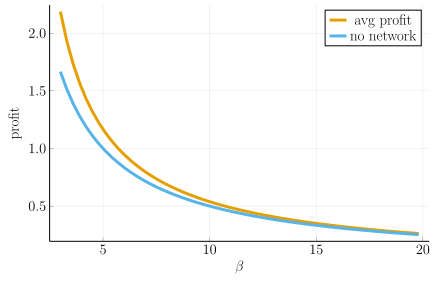

In [25]:
p = plot(x, profits_i, xlabel=L"\beta",ylabel = "profit", label = "avg profit", lw = 3,legend = :topright,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size) #title = "Profit comparison "
#plot!(x, profits_i_max,  lw = 3,label = "max profit")
#plot!(x, profits_i_min, lw = 3,label = "min profit")
plot!(x, profits_no, label = "no network",lw = 3)#,legend = :topleft)
savefig("profit_no_net_beta_"*fig_name*".pdf")
p

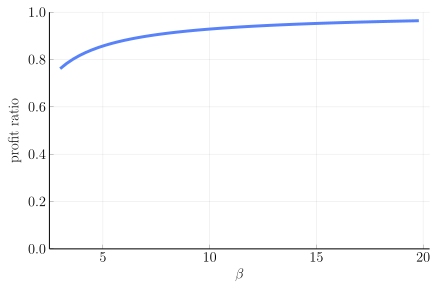

In [14]:
p = plot(x, profits_no./profits_i, xlabel=L"\beta",ylabel = "profit ratio",  color = "#5882FA",
    #label = "avg discrimination - avg single wage",
    ylims=(0,1),#xticks=25:5:75,
    legend = false,
    lw = 3,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size) #title = "Profit comparison "
savefig("profit_ratio_no_net_beta_0_1_"*fig_name*".pdf")
p

## Intensity of network effects

In [15]:
#Generating profits by matrixes and gammas
initialize_parameters(3,1,20)
#list of generated matrixes
matrixes = []
#list of transpose matrixes
matrixes_t = []
# generating k matrixes for each beta
k = 100
for j in 1:k
        mat = generator(β,n,γ); #j = beta 
        push!(matrixes, mat);
        push!(matrixes_t,mat');
end
profits_i = []
profits_no = []
x=(γ-1):0.03:(γ)
for i in x
    print("--",i,"--")
    profits = profit.(matrixes,i,β)
    push!(profits_i,sum(profits/k)) #avg profits
    #push!(profits_i_max,findmax(profits)[1]) #max profits
    #push!(profits_i_min,findmin(profits)[1]) #min profits
    push!(profits_no,profit_no_network(n,β)) # no network
end

--0.0----0.03----0.06----0.09----0.12----0.15----0.18----0.21----0.24----0.27----0.3----0.33----0.36----0.39----0.42----0.45----0.48----0.51----0.54----0.57----0.6----0.63----0.66----0.69----0.72----0.75----0.78----0.81----0.84----0.87----0.9----0.93----0.96----0.99--

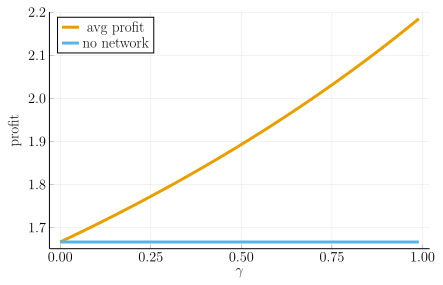

In [16]:
p = plot(x, profits_i,xlabel =L"\gamma", ylabel = "profit", label = "avg profit", lw = 3,legend = :best) #title = "Profit comparison "
plot!(x, profits_no, lw = 3,label = "no network",legend = :topleft,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size)
savefig("profit_no_net_gamma_"*fig_name*".pdf")
p

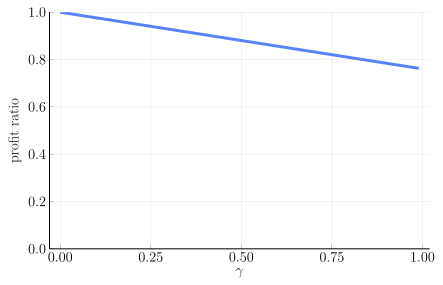

In [17]:
p = plot(x, profits_no./profits_i, xlabel=L"\gamma",ylabel = "profit ratio",  color = "#5882FA",
    #label = "avg discrimination - avg single wage",
    ylims=(0,1),#xticks=25:5:75,
    legend = false,
    lw = 3,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size) #title = "Profit comparison "
savefig("profit_ratio_no_net_gamma_0_1_"*fig_name*".pdf")
p

## Number of workers

In [18]:
#Generating profits by matrixes and n
k=50
# matrixes are generatd from 1 to 1_max
n_max = 100
# profits
profits_i = []
profits_i_min = []
profits_i_max = []
profits_no = []

x = 2:n_max
# loop by number of workers
for j in x
    print("--",j)
    n_ = j
    Id = Matrix{Int}(I,n_,n_) #Identity matrix nxn
    ones_ = fill(1,n_)
    matrixes = []
    #loop by matrixes
    for i in 1:k
        #mat = generator(β,n_,γ, n_^2)# keeps constant the sum of columns and rows
        mat = generator(β,n_,γ, n_max/2+20) # passing the limits of the random generation
        push!(matrixes, mat);
    end
    profits = profit.(matrixes,γ,β)
    push!(profits_i,sum(profits/k)) #avg profits
    push!(profits_no,profit_no_network(n_,β)) #min profits
end

--2--3--4--5--6--7--8--9--10--11--12--13--14--15--16--17--18--19--20--21--22--23--24--25--26--27--28--29--30--31--32--33--34--35--36--37--38--39--40--41--42--43--44--45--46--47--48--49--50--51--52--53--54--55--56--57--58--59--60--61--62--63--64--65--66--67--68--69--70--71--72--73--74--75--76--77--78--79--80--81--82--83--84--85--86--87--88--89--90--91--92--93--94--95--96--97--98--99--100

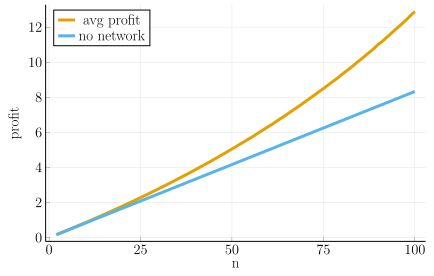

In [19]:
p = plot(x, profits_i , xlabel = "n",ylabel = "profit", label = "avg profit", lw = 3,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size) #,title = "Profit comparison "
#plot!(x, profits_i_max,  lw = 3,label = "max profit")
#plot!(x, profits_i_min, lw = 3,label = "min profit")
plot!(x, profits_no, lw = 3,label = "no network", legend = :topleft)
savefig("profit_no_net_n_"*fig_name*".pdf")
p

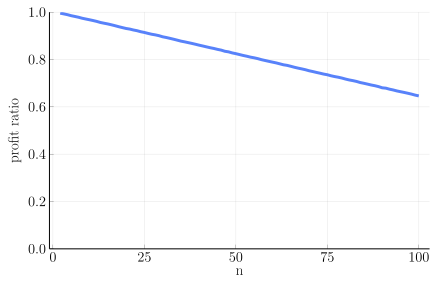

In [20]:
p = plot(x, profits_no./profits_i, xlabel="n",ylabel = "profit ratio", color = "#5882FA",
    #label = "avg discrimination - avg single wage",
    ylims=(0,1),#xticks=25:5:75,
    legend = false,
    lw = 3,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size) #title = "Profit comparison "
savefig("profit_ratio_no_net_n_0_1_"*fig_name*".pdf")
p

# Comparison single wage and perfect discrimination

## Efforts and Wages

### Random graph

In [26]:
# initializing parameters beta = 3, gamma = 1/4 , n = 7
initialize_parameters(3,1/4,10)
# Using random generated matrixes
G = random_matrix(β,n,γ,n/1.2);
# random matrix for example
println(G)
println("***********************************")
# Matrix 
eff_simp = effort_single(β,G,γ)
wag_simp = wage_single(β,G,γ)
profit_simp = profit_single(β,G,γ)
out_simp = output(eff_simp*ones_,G,γ)
println("single effort: ",eff_simp)
println("single wage: ",wag_simp)
println("single wage output ", out_simp)
println("single wage profit ", profit_simp)
println("***********************************")
printer(β,γ,G)
eff = sort(effort(β,G,γ))
wage_lin = eff*β
wag = sort(wage(β,G,γ))
bon = eff*(2*β);

Real[0 1.2495447857957767 1.1713417276175186 1.3024636687404318 1.3266217279962387 0.8386763486717688 0.4227053587524017 1.2525732844693802 0.8035150656265942 0.11807618441717602; 0 0 0.9914688723881906 0.5985906567853841 0.42840066188522646 0.5754514970838734 0.9390239449896356 0.4676731165382277 1.2469994836517595 0.9634786500152602; 0 0 0 0.022516836507950694 0.8006231662224839 0.11683608692772705 1.0572182617908885 1.2438422065550931 0.017753236450567762 0.8804552381642886; 0 0 0 0 0.25700350517172077 0.44217528912898957 0.7938006193134287 1.371019594904448 0.5274338134184939 0.3247783386090745; 0 0 0 0 0 0.18603333962191887 0.11849964959824885 1.315451498100539 1.0127225671240185 0.3540473404229945; 0 0 0 0 0 0 0.2915969664036088 0.28812745153439123 0.6578772391309247 0.938635088240657; 0 0 0 0 0 0 0 0.024033331445806532 0.2525178568989919 1.3419879684212652; 0 0 0 0 0 0 0 0 0.989909456254579 1.2218183660549071; 0 0 0 0 0 0 0 0 0 0.30949318160181327; 0 0 0 0 0 0 0 0 0 0]
*********

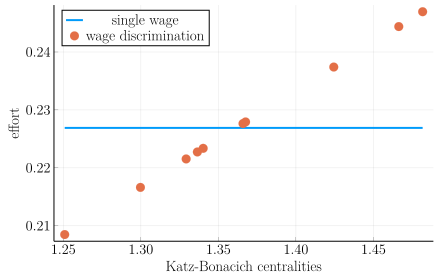

In [28]:
# Ploting effort
p1 = plot(bon, fill(eff_simp,length(bon)),
    xlabel ="Katz-Bonacich centralities",
    ylabel = "effort",
    label = "single wage",
    lw = 2, 
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size,
    color = "#009bfa", 
    legend = :topleft
    ) #title = "Profit comparison "

scatter!(bon,
    eff,
    label = "wage discrimination",
    markersize = 6,
    markercolor = "#e36f47",
    markerstrokewidth = 0,
    markerstrokecolor = "#e36f47",
)
savefig("profit_single_comp_effort.pdf")

p1

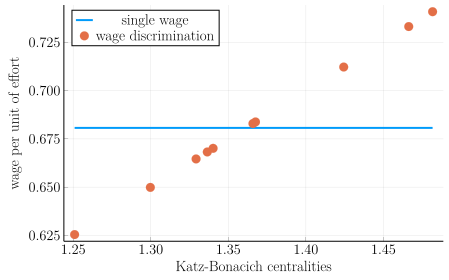

In [30]:
# Ploting wage
p2 = plot(bon, fill(wag_simp/eff_simp,length(bon)),
    xlabel ="Katz-Bonacich centralities",
    ylabel = "wage per unit of effort", 
    label = "single wage",
    lw = 2, 
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size,
    color = "#009bfa", 
    legend = :topleft) #title = "Profit comparison " #ylims = (min(wag_simp,wag[1])-0.01,wag[n]+10)

scatter!(bon,
    wage_lin,
    label = "wage discrimination",
    markersize = 6,
    markercolor = "#e36f47",
    markerstrokewidth = 0,
    markerstrokecolor = "#e36f47",
)
savefig("profit_single_comp_wage.pdf")

p2
#:right, :left, :top, :bottom, :inside, :best, :legend, :topright, :topleft, :bottomleft, :bottomright :outertopright

### Stars

In [86]:
# initializing parameters beta = 3, gamma = 1/4 , n = 7
initialize_parameters(3,1/4,100)
# Using random generated matrixes
G = random_star(β,n,γ,n/1.3);
# random matrix for example
#print(G)
println("***********************************")
# Matrix 
eff_simp = effort_single(β,G,γ)
wag_simp = wage_single(β,G,γ)
profit_simp = profit_single(β,G,γ)
out_simp = output(eff_simp*ones_,G,γ)
println("single effort: ",eff_simp)
println("single wage: ",wag_simp)
println("single wage output ", out_simp)
println("single wage profit ", profit_simp)
println("***********************************")
printer(β,γ,G)
eff = sort(effort(β,G,γ))
wage_lin = eff*β
wag = sort(wage(β,G,γ))
bon = eff*(2*β);

***********************************
single effort: 0.17033654616603033
single wage: 0.08704361687931655
single wage output 17.22118899623318
single wage profit 8.516827308301517
***********************************
**************Parameters************
beta :3 gamma: 0.25 n: 100
************************************
effort: [0.35090895565045743, 0.17147807479764074, 0.16979190239743802, 0.17146773101328547, 0.16840817436473518, 0.16895897508364185, 0.17166117434998215, 0.167374022576898, 0.1705907531876486, 0.17207656503371893, 0.17133815811822362, 0.17163787238292796, 0.17059104705277703, 0.1722992492608362, 0.17159303134337855, 0.17161788127608976, 0.16823786334595567, 0.1712454092899345, 0.17231139533484066, 0.1718283233115181, 0.16927999255663403, 0.16992907051941308, 0.16799788179280783, 0.1724092301250402, 0.1718087860641043, 0.16846312900254665, 0.1719223493010628, 0.16980602479069598, 0.17181459244489528, 0.17056166850586518, 0.16954415606391138, 0.16858655772620035, 0.16903050701

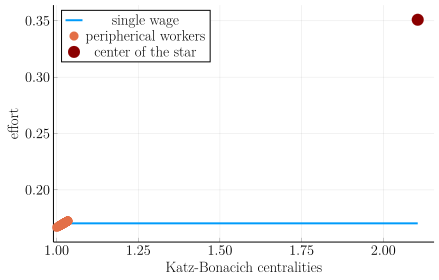

In [87]:
# Ploting effort
p1 = plot(bon, fill(eff_simp,length(bon)),xlabel ="Katz-Bonacich centralities",ylabel = "effort",
    label = "single wage",
    xlims = (bon[1]-0.01,bon[n]+0.05),
    ylims = (min(eff_simp,eff[1])-0.013,eff[n]+0.013),
    lw = 2,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size,
    color = "#009bfa", 
    legend = :topleft) #title = "Profit comparison "

scatter!(bon,
    eff,
    label = "peripherical workers",
    markersize = 6,
    markercolor = "#e36f47",
    markerstrokewidth = 0,
    markerstrokecolor = "#e36f47",
)

scatter!([bon[n]],
    [eff[n]],
    label = "center of the star",
    markersize = 8,
    markercolor = :darkred,
    markerstrokewidth = 0,
    markerstrokecolor = :darkred,
)
savefig("profit_single_comp_effort_star_"*string(n)*".pdf")

p1

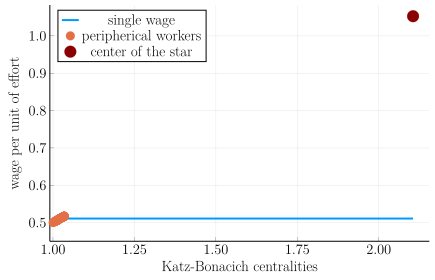

In [88]:
# Ploting wage
p2 = plot(bon, fill(wag_simp/eff_simp,length(bon)),xlabel ="Katz-Bonacich centralities",ylabel = "wage per unit of effort", 
    label = "single wage",
    xlims = (bon[1]-0.01,bon[n]+0.05),
    ylims = (min(wag_simp/eff_simp,wage_lin[1])-0.05,wage_lin[n]+0.03),
    lw = 2,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size,
    color = "#009bfa", 
    legend = :topleft) #title = "Profit comparison " #ylims = (min(wag_simp,wag[1])-0.01,wag[n]+10)

scatter!(bon,
    wage_lin,
    label = "peripherical workers",
    markersize = 6,
    markercolor = "#e36f47",
    markerstrokewidth = 0,
    markerstrokecolor = "#e36f47"
)
scatter!([bon[n]],
    [wage_lin[n]],
    label = "center of the star",
    markersize = 8,
    markercolor = :darkred,
    markerstrokewidth = 0,
    markerstrokecolor = :darkred,
)
savefig("profit_single_comp_wage_star_"*string(n)*".pdf")

p2

### Lines

In [104]:
# initializing parameters beta = 3, gamma = 1/4 , n = 7
initialize_parameters(3,1/4,100)
# Using random generated matrixes
G = random_line(β,n,γ,n/1.2);
# random matrix for example
#print(G)
# println("***********************************")
# Matrix 
# eff_simp = effort_single(β,G,γ)
# wag_simp = wage_single(β,G,γ)
# profit_simp = profit_single(β,G,γ)
# out_simp = output(eff_simp*ones_,G,γ)
# println("single effort: ",eff_simp)
# println("single wage: ",wag_simp)
# println("single wage output ", out_simp)
# println("single wage profit ", profit_simp)
# println("***********************************")
# printer(β,γ,G)
eff_original = effort(β,G,γ)
eff = sort(eff_original)
wage_lin = eff*β
wag = sort(wage(β,G,γ))
bon = eff*(2*β);

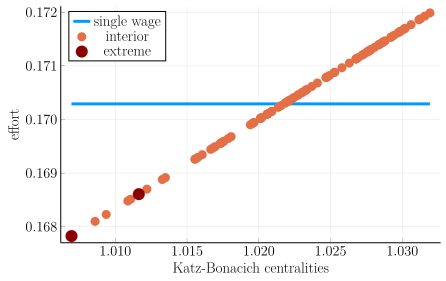

In [105]:
# Ploting effort
p = plot(bon, fill(eff_simp,length(bon)),xlabel ="Katz-Bonacich centralities",ylabel = "effort",
    label = "single wage", lw = 3, 
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size,
    color = "#009bfa", 
    legend = :topleft) #title = "Profit comparison "

scatter!(bon,
    eff,
    label = "interior",
    markersize = 6,
    markercolor = "#e36f47",
    markerstrokewidth = 0,
    markerstrokecolor = "#e36f47"
)

bon = eff_original*(2*β)

scatter!([bon[1],bon[n]],
    [eff_original[1],eff_original[n]],
    label = "extreme",
    markersize = 8,
    markercolor = :darkred,
    markerstrokewidth = 0,
    markerstrokecolor = :darkred,
)


# scatter!([bon[Int(n/2)],bon[Int(n/2)+1]],
#     [eff_original[Int(n/2)],eff_original[Int(n/2)+1]],
#     label = "center",
#     markersize = 8,
#     markercolor = :yellow,
#     markerstrokewidth = 0,
#     markerstrokecolor = :darkred,
# )

savefig("profit_single_comp_effort_line_"*string(n)*".pdf")

p

### Preferential Attachment

In [112]:
# initializing parameters beta = 3, gamma = 1/4 , n = 7
initialize_parameters(3,1/4,20)
# Using random generated matrixes
G = preferential_attachment(β,n,γ);
#G = zeros(n,n)
# random matrix for example
#println(G)
# println("***********************************")
# Matrix 
eff_simp = effort_single(β,G,γ)
wag_simp = wage_single(β,G,γ)
profit_simp = profit_single(β,G,γ)
out_simp = output(eff_simp*ones_,G,γ)
# println("single effort: ",eff_simp)
# println("single wage: ",wag_simp)
# println("single wage output ", out_simp)
# println("single wage profit ", profit_simp)
# println("***********************************")
# printer(β,γ,G)
eff = sort(effort(β,G,γ))
wage_lin = eff*β
wag = sort(wage(β,G,γ))
bon = eff*(2*β);

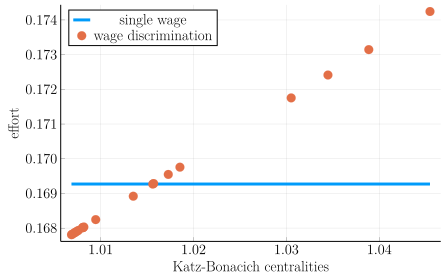

In [113]:
# Ploting effort
p1 = plot(bon, fill(eff_simp,length(bon)), xlabel ="Katz-Bonacich centralities", ylabel = "effort",
    label = "single wage", 
    lw = 3,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size,
    color = "#009bfa", 
    legend = :topleft) #title = "Profit comparison "

scatter!(bon,
    eff,
    label = "wage discrimination",
    markersize = 6,
    markercolor = "#e36f47",
    markerstrokewidth = 0,
    markerstrokecolor = "#e36f47"
)
savefig("profit_single_comp_effort_pa_"*string(n)*".pdf")
    
p1

## Comparison of profit gap and profit ratio
Profit gap : $\pi_d - \pi_s$

Profit ratio : $\frac{\pi_s}{\pi_d}$

In [127]:
# choosing generator (network structure), set one of the following structures:
# random_matrix for uniformly random networks 
# random_star for star networks 
# ramdom_line for line networks 
# preferential_attachment for preferential attachment networks
#generator = preferential_attachment


preferential_attachment (generic function with 2 methods)

### Effort disutility

In [72]:
#Generating profits by matrixes and betas(i)
# initializing parameters beta = 3, gamma = 1/4 , n = ...
initialize_parameters(3,1/4,50)
println("**************Parameters************")
println("beta :",β," gamma: ",γ," n: ",n )
println("************************************")
k = 50
profits_disc = []
profits_sing = []
# list of values of betas
x=(β):0.02:(β+3)
#list of generated matrixes
matrixes = []
#list of transpose matrixes
matrixes_t = []
# generating k matrixes for each beta
for j in 1:k
    print("--",j)
    mat = generator(β,n,γ, n/2); #j = beta 
    push!(matrixes, mat);
    push!(matrixes_t,mat');
end
#looping in the lis of values
for i in x
    profits = profit.(matrixes,γ,i) # the profit of each matrix given beta = i
    push!(profits_disc,sum(profits/k)) # avg profits
    profits = profit_single.(i,matrixes,γ)
    push!(profits_sing,sum(profits/k)) # min profits
end

**************Parameters************
beta :3 gamma: 0.25 n: 50
************************************
--1--2--3--4--5--6--7--8--9--10--11--12--13--14--15--16--17--18--19--20--21--22--23--24--25--26--27--28--29--30--31--32--33--34--35--36--37--38--39--40--41--42--43--44--45--46--47--48--49--50

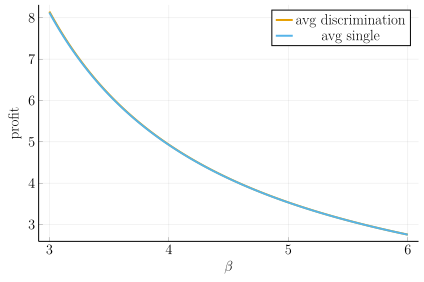

In [73]:

p = plot(x, profits_disc, xlabel=L"\beta",ylabel = "profit", label = "avg discrimination", lw = 2,legend=:topright,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size) #title = "Profit comparison "
plot!(x, profits_sing, lw = 2,label = "avg single")
#savefig("profit_dic_sing_beta.pdf")
p

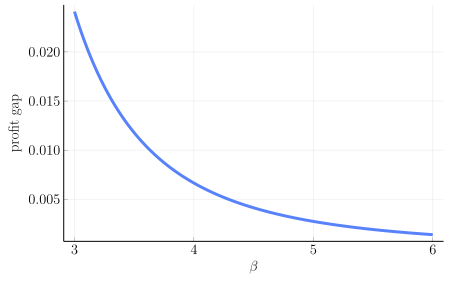

In [74]:
p = plot(x, profits_disc - profits_sing, xlabel=L"\beta",ylabel = "profit gap", color = "#5882FA",
    #label = "avg discrimination - avg single wage",
    legend = false,
    lw = 3,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size) #title = "Profit comparison "
#plot!(x, profits_sing, lw = 2,label = "avg single")
savefig("profit_gap_beta_"*fig_name*".pdf")
p

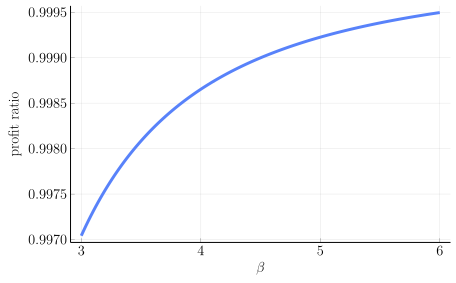

In [75]:
p = plot(x, profits_sing./profits_disc, xlabel=L"\beta",ylabel = "profit ratio", color= "#5882FA",
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size,
    #label = "avg discrimination - avg single wage",
#    ylims=(0,1),#xticks=25:5:75,
    legend = false,
    lw = 3) #title = "Profit comparison "
#plot!(x, profits_sing, lw = 2,label = "avg single")
savefig("profit_ratio_beta_"*fig_name*".pdf")
p

### Intensity of network effects

In [76]:
#Generating profits by matrixes and gammas
# initializing parameters beta = 3, gamma = 1/4 , n = ...
initialize_parameters(3,1/4,50)
println("**************Parameters************")
println("β:",β," γ: ",γ," n: ",n )
println("************************************")
println("**** intensity of interactions *****")
k = 50
profits_disc = []
profits_sing = []
γ=1
# list of values of betas
x=(γ-1):0.01:(γ)
#list of generated matrixes
matrixes = []
#list of transpose matrixes
matrixes_t = []
# generating k matrixes for each beta
for j in 1:k
    print("--",j)
    #mat = generator(β,n,γ, n^2); 
    mat = generator(β,n,γ, n/2); 
    #mat = generator(β,n,γ, n);
    push!(matrixes, mat);
    push!(matrixes_t,mat');
end
#looping in the lis of values
for i in x
    profits = profit.(matrixes,i,β) # the profit of each matrix given beta = i
    push!(profits_disc,sum(profits/k)) # avg profits
    profits1 = profit_single.(β,matrixes,i)
    push!(profits_sing,sum(profits1/k))
end

**************Parameters************
β:3 γ: 0.25 n: 50
************************************
**** intensity of interactions *****
--1--2--3--4--5--6--7--8--9--10--11--12--13--14--15--16--17--18--19--20--21--22--23--24--25--26--27--28--29--30--31--32--33--34--35--36--37--38--39--40--41--42--43--44--45--46--47--48--49--50

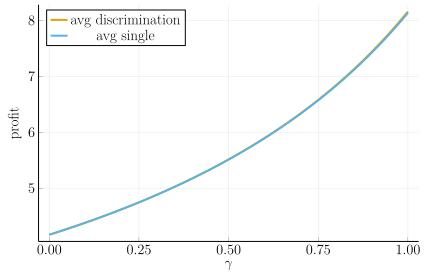

In [77]:
p = plot(x, profits_disc, xlabel = L"\gamma",ylabel = "profit", label = "avg discrimination", lw = 2) #,title = "Profit comparison "
plot!(x, profits_sing, lw = 2,label = "avg single", legend = :topleft,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size,)
#savefig("profit_dic_sing_gamma.pdf")
p 

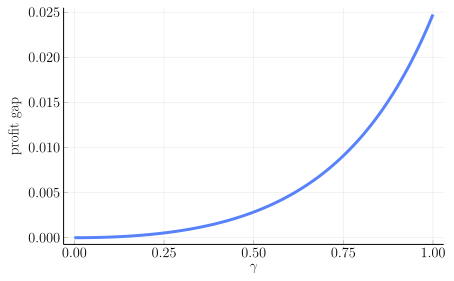

In [78]:
p = plot(x, profits_disc - profits_sing, xlabel=L"\gamma",ylabel = "profit gap", color = "#5882FA",
    #label = "avg discrimination - avg single wage",
    legend = false,
    lw = 3,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size) #title = "Profit comparison "
#plot!(x, profits_sing, lw = 2,label = "avg single")
savefig("profit_gap_gamma_"*fig_name*".pdf")
p

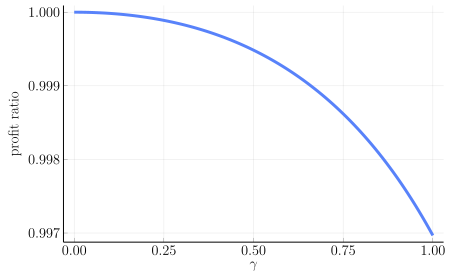

In [79]:
p = plot(x, profits_sing./profits_disc, xlabel=L"\gamma",ylabel = "profit ratio", color = "#5882FA", 
    #label = "avg discrimination - avg single wage",
#    ylims=(0,1),#xticks=25:5:75,
    legend = false,
    lw = 3,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size) #title = "Profit comparison "
#plot!(x, profits_sing, lw = 2,label = "avg single")
savefig("profit_ratio_gamma_"*fig_name*".pdf")
p

### Number of workers

In [65]:
#Generating profits by matrixes and n, parameters
β = 3
k=40
n_max =100
initialize_parameters(3,1/4,10) #0.5 interesting result
profits_disc = []
profits_sing = []
println("**************Parameters************")
println("β:",β," γ: ",γ," n: ",n ," γ/(2β):", γ/(2*β)," β/γ : ", β/γ)
println("************************************")
println("******** number of workers *********")
x = 2:n_max
# loop by number of workers
for j in x
    print(" -- ",j)
    n_ = j
    Id = Matrix{Int}(I,n_,n_) #Identity matrix nxn
    ones_ = fill(1,n_)
    matrixes = []
    #loop by matrixes
    for i in 1:k
        #mat = generator(β,n_,γ)# keeps constant the sum of columns and rows n^2! 
        mat = generator(β,n_,γ, n_^2) # passing the limits of the random generation, g bar fixed
        #mat = generator(β,n_,γ, n_max/2+20) # passing the limits of the random generation  #not fixing g bar
        push!(matrixes, mat);
    end
    g_b = ones_'*matrixes[1]*ones_
    print(" 2gγ/β =", (2 *g_b*γ)/β)
    profits = profit.(matrixes,γ,β)
    push!(profits_disc,sum(profits/k)) #avg profits
    profits = profit_single.(β,matrixes,γ)
    push!(profits_sing,sum(profits/k)) #min profits
end

**************Parameters************
β:3 γ: 0.25 n: 10 γ/(2β):0.041666666666666664 β/γ : 12.0
************************************
******** number of workers *********
 -- 2 2gγ/β =0.4176792937872797 -- 3 2gγ/β =0.40304369025447967 -- 4 2gγ/β =0.49638763020247745 -- 5 2gγ/β =0.4609474293759566 -- 6 2gγ/β =0.3692252144636505 -- 7 2gγ/β =0.4786327852838213 -- 8 2gγ/β =0.4769045471386821 -- 9 2gγ/β =0.5110770559863389 -- 10 2gγ/β =0.457039531727939 -- 11 2gγ/β =0.4996921868897079 -- 12 2gγ/β =0.5016778533869796 -- 13 2gγ/β =0.4779137610450009 -- 14 2gγ/β =0.45505146586604245 -- 15 2gγ/β =0.5224349028624217 -- 16 2gγ/β =0.5200276146112603 -- 17 2gγ/β =0.48599032913421447 -- 18 2gγ/β =0.496190785461565 -- 19 2gγ/β =0.496261569397011 -- 20 2gγ/β =0.46943273726539086 -- 21 2gγ/β =0.493767214808227 -- 22 2gγ/β =0.5000548346192638 -- 23 2gγ/β =0.48795664821902845 -- 24 2gγ/β =0.4598981362612066 -- 25 2gγ/β =0.4929983400890298 -- 26 2gγ/β =0.48530857827744683 -- 27 2gγ/β =0.4641133291812241 -- 2

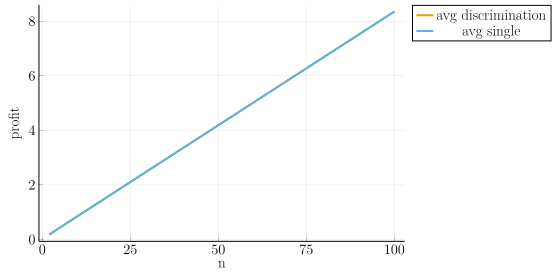

In [66]:
p = plot(x, profits_disc, xlabel = "n",ylabel = "profit", label = "avg discrimination", lw = 2) #,title = "Profit comparison "
plot!(x, profits_sing, lw = 2,label = "avg single",
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size)
# savefig("profit_dic_sing_n_"*fig_name*".pdf")
savefig("profit_dic_sing_n_g_fixed_"*fig_name*".pdf")
p

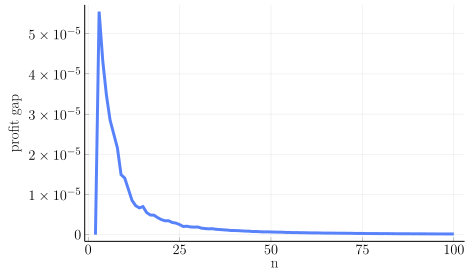

In [67]:
p = plot(x, profits_disc - profits_sing, xlabel="n",ylabel = "profit gap", color = "#5882FA", 
    #label = "avg discrimination - avg single wage",
    legend = false,
    lw = 3,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size) #title = "Profit comparison "

# savefig("profit_gap_n_"*fig_name*".pdf")
savefig("profit_gap_n_g_fixed_"*fig_name*".pdf")
p

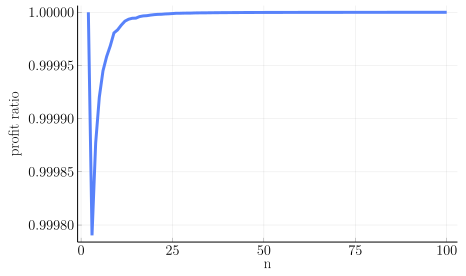

In [68]:
p = plot(x, profits_sing./profits_disc, xlabel="n",ylabel = "profit ratio", color = "#5882FA", 
    #label = "avg discrimination - avg single wage",
#    ylims=(0,1),#xticks=25:5:75,
    legend = false,
    lw = 3,
    yguidefontsize=font_size,
    legendfontsize=font_size,
    xtickfontsize=font_size,
    ytickfontsize=font_size,
    xguidefontsize=font_size) #title = "Profit comparison "

# savefig("profit_ratio_n_"*fig_name*".pdf")
savefig("profit_ratio_n_g_fixed_"*fig_name*".pdf")
p

# Painting networks

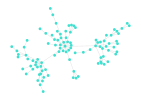

In [115]:
# using Pkg
# Pkg.add("LightGraphs")
# Pkg.add("SimpleWeightedGraphs")
# Pkg.add("GraphPlot")
using LightGraphs, SimpleWeightedGraphs, GraphPlot
# A = random_star(β, 10, γ, 0)   
A = preferential_attachment(β,100,γ)
g = Graph(A+A')
gplot(g)

# A = random_line(β, 10, γ, 0)       
# g = Graph(A+A')
# gplot(g)


# Debugging

In [164]:
G = [0 0 1; 4 0 2;4 2 0]
initialize_parameters(3,1/4,3)
println(γ)
println(n)

println("single effort: ",effort_single(β,G,γ))
println("single wage: ",wage_single(β,G,γ))

a = [ 0.2, 0.5, 0.9]

println(a'*G*a)
println(a'*G'*a)

0.25
3
single effort: 0.2608695652173913
single wage: 0.2041587901701323
3.1
3.1


In [165]:

println(profit(G, γ,β))
println(effort( γ,G,β))
println(profit(0.2*G+0.8*G', γ,β))
G_=0.2*G+0.8*G'
println("******** G *********")
printer(β,γ,G)
#println("**** 0.2*G+0.8*G' ****")
#printer(β,γ,G_)



0.391509433962264
[-0.042337, -0.0321761, -0.042337]
0.39150943396226423
******** G *********
**************Parameters************
beta :3 gamma: 0.25 n: 3
************************************
effort: [0.264151, 0.254717, 0.264151]
wage: [0.209327, 0.194642, 0.209327]
output: 1.0048059807760767
profit1: 0.391509433962264
profit2: 0.391509433962264
profit_no_network: 0.25


In [166]:
condition_largest_eigenvalue(G,γ/(2*β))

true

In [167]:
katz_bonacich(γ/(2*β), symmetrized_network(G))

3-element Array{Float64,1}:
 1.5849056603773584
 1.528301886792453 
 1.5849056603773586

In [168]:
random_matrix(β, n, γ)

3×3 Array{Real,2}:
 0  3.96119  1.64377 
 0  0        0.297771
 0  0        0       

In [169]:
printer(β, γ, matrixes[1])

**************Parameters************
beta :3 gamma: 0.25 n: 3
************************************


DimensionMismatch: DimensionMismatch("dimensions must match")

In [46]:
random_matrix(β, n, γ)

3×3 Array{Real,2}:
 0  0.194207  3.53144
 0  0         3.95102
 0  0         0      

In [47]:
eigen(M+M')

UndefVarError: UndefVarError: M not defined

In [48]:
inv(Id - 0.01*G)*ones_

3-element Array{Float64,1}:
 1.0106165781951817
 1.0616578195181707
 1.0616578195181707

In [348]:
profit(0.5 * matrixes[1] + 0.5 * matrixes[1]', γ, β)

---true
---true


0.5468387558156265

In [345]:
profit(matrixes[1]', γ, β)

---true
---true


0.5468387558156265

In [61]:
e = [-0.22,2,3,5]
e < [0,0,0,0]
fig_name

""

In [236]:
Id = [1 0 0; 0 1 0;0 0 1]
([1, 2, 7]*[1 1 1])

3×3 Array{Int64,2}:
 1  1  1
 2  2  2
 7  7  7